<a href="https://colab.research.google.com/github/LilianaSP/ChatBot-WhatsApp-API/blob/main/face_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face detection using pre-trained model

We use following blog as a reference:
[Face detection with OpenCV and deep learning](https://www.pyimagesearch.com/2018/02/26/face-detection-with-opencv-and-deep-learning/)

Import required Python libraries

In [ ]:

import imutils
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

Start webcam

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

Click 'Capture' to make photo using your webcam.

In [ ]:
image_file = take_photo()

Read, resize and display the image.

In [ ]:
#image = cv2.imread(image_file, cv2.IMREAD_UNCHANGED)
image = cv2.imread(image_file)

# resize it to have a maximum width of 400 pixels
image = imutils.resize(image, width=400)
(h, w) = image.shape[:2]
print(w,h)
cv2_imshow(image)

OpenCV’s deep learning face detector is based on the Single Shot Detector (SSD) framework with a ResNet base network. The network is defined and trained using the [Caffe Deep Learning framework](https://caffe.berkeleyvision.org/)

Download the pre-trained face detection model, consisting of two files:

- The network definition (deploy.prototxt)
- The learned weights (res10_300x300_ssd_iter_140000.caffemodel)

COMENTARIO: La red Neuronal tiene un kernel size de 3. Donde ReLU es la función de activación.

In [ ]:
!wget -N https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt



COMENTARIO: En esta línea se carga el pretrained data set


!wget -N https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

Load the pre-trained face detection network model from disk

In [ ]:
print("[INFO] loading model...")
prototxt = 'deploy.prototxt'
model = 'res10_300x300_ssd_iter_140000.caffemodel'
net = cv2.dnn.readNetFromCaffe(prototxt, model)

Use the [dnn.blobFromImage](https://www.pyimagesearch.com/2017/11/06/deep-learning-opencvs-blobfromimage-works/) function to construct an input blob by resizing the image to a fixed 300x300 pixels and then normalizing it.

COMENTARIO: Esta función realiza tres operaciones principales:

Sustracción de la media: Resta los valores promedio de RGB (calculados previamente del conjunto de datos de entrenamiento) para combatir cambios de iluminación.
Escalado: Aplica opcionalmente un factor de escala para normalizar los valores de píxeles.
Intercambio de canales: Cambia los canales Red y Blue (R y B) porque OpenCV usa orden BGR mientras que muchos modelos esperan RGB.

Esto es para ajustar las imágenes a lo que la red espera y se le da el peso.


In [ ]:
# resize it to have a maximum width of 400 pixels
image = imutils.resize(image, width=400)
blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))


Pass the blob through the neural network and obtain the detections and predictions.

In [ ]:
print("[INFO] computing object detections...")
net.setInput(blob)
detections = net.forward()

Loop over the detections and draw boxes around the detected faces

In [ ]:
for i in range(0, detections.shape[2]):

	# extract the confidence (i.e., probability) associated with the prediction
	confidence = detections[0, 0, i, 2]

	# filter out weak detections by ensuring the `confidence` is
	# greater than the minimum confidence threshold
	if confidence > 0.5:
		# compute the (x, y)-coordinates of the bounding box for the object
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")
		# draw the bounding box of the face along with the associated probability
		text = "{:.2f}%".format(confidence * 100)
		y = startY - 10 if startY - 10 > 10 else startY + 10
		cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
		cv2.putText(image, text, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

Show the resulting image

COMENTARIO: En este paso se realiza la validación del modelo cargando los datos de la foto que se tomó con la cámara web. Donde la menor precisión que se obtuvo del modelo es de 52.83%

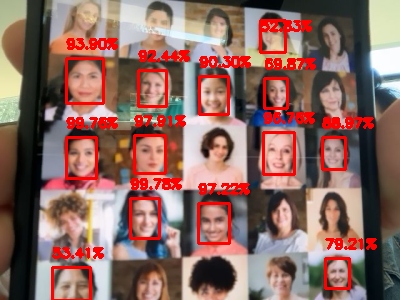

In [29]:
cv2_imshow(image)